# Introduction

Welcome to the **Few Shot Object Detection for TensorFlow Lite** Colab. Here, we demonstrate fine tuning of a SSD architecture (pre-trained on COCO) on very few examples of a *novel* class. We will then generate a (downloadable) TensorFlow Lite model for on-device inference.

**NOTE:** This Colab is meant for the few-shot detection use-case. To train a model on a large dataset, please follow the [TF2 training](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_training_and_evaluation.md#training) documentation and then [convert](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_on_mobile_tf2.md) the model to TensorFlow Lite.

# Set Up

## Imports

In [1]:
# Support for TF2 models was added after TF 2.3.
!pip install tf-nightly
# ! pip install tensorflow

In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/lorynebissuel/models

In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Using cached https://files.pythonhosted.org/packages/d6/84/759f5dd23fec8ba71952d97bcc7e2c9d7d63bdc582421f3cd4be845f0c98/gast-0.3.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/60/06/cafdd44889200e5438b897388f3075b52a8ef01f28a17366d91de0fa2d05/h5py-2.10.0-cp36-cp36m-manylinux1_x86_64.whl
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1608663 sha256=519b25368dbb0c402f3e149a25c25a0eadc7ee955b9c0aec6a44bf2f11ef0317
  Stored in directory: /tmp/pip-ephem-wheel-cache-081l8va8/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: h5py 3.1.0
    Uninstal

ERROR: tf-nightly 2.5.0.dev20210119 has requirement gast==0.4.0, but you'll have gast 0.3.3 which is incompatible.
ERROR: tf-nightly 2.5.0.dev20210119 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.


In [4]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder

%matplotlib inline

##Utilities

In [5]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


## Rubber Ducky data

We will start with some toy data consisting of 5 images of a rubber
ducky.  Note that the [COCO](https://cocodataset.org/#explore) dataset contains a number of animals, but notably, it does *not* contain rubber duckies (or even ducks for that matter), so this is a novel class.

In [8]:
# # Load images and visualize
# train_image_dir = 'models/research/object_detection/test_images/ducky/train/'
# train_images_np = []
# for i in range(1, 6):
#   image_path = os.path.join(train_image_dir, 'robertducky' + str(i) + '.jpg')
#   train_images_np.append(load_image_into_numpy_array(image_path))

# plt.rcParams['axes.grid'] = False
# plt.rcParams['xtick.labelsize'] = False
# plt.rcParams['ytick.labelsize'] = False
# plt.rcParams['xtick.top'] = False
# plt.rcParams['xtick.bottom'] = False
# plt.rcParams['ytick.left'] = False
# plt.rcParams['ytick.right'] = False
# plt.rcParams['figure.figsize'] = [14, 7]

# for idx, train_image_np in enumerate(train_images_np):
#   plt.subplot(2, 3, idx+1)
#   plt.imshow(train_image_np)
# plt.show()

In [6]:
# Load images and visualize
train_images_path = 'models/research/object_detection/data'
train_image_dataset = 'models/research/object_detection/data/tagged_images_with_all_coords.csv'
train_images_np = []

# df_tagged_dataset["top"] = df_tagged_dataset["top"].astype(float)
# df_tagged_dataset["top"] = df_tagged_dataset["top"].astype(float)
# df_tagged_dataset["top"] = df_tagged_dataset["top"].astype(float)
# df_tagged_dataset["top"] = df_tagged_dataset["top"].astype(float)

df_tagged_dataset = pd.read_csv(train_image_dataset)
df_tagged_dataset[["id", "tag", "left", "top", "right", "bottom", "height", "width"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2254 entries, 0 to 2253
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      2254 non-null   object 
 1   tag     2254 non-null   object 
 2   left    2254 non-null   float64
 3   top     2254 non-null   float64
 4   right   2254 non-null   float64
 5   bottom  2254 non-null   float64
 6   height  2254 non-null   float64
 7   width   2254 non-null   float64
dtypes: float64(6), object(2)
memory usage: 141.0+ KB


In [7]:
person_tags = df_tagged_dataset[df_tagged_dataset["tag"]=="Person"][:10]
person_tags = person_tags.reset_index(drop=True)
person_tags

,height,id,left,tag,top,width,bottom,right
0,0.831224,79e39c6d-f0de-4deb-b603-ffc0b39bcf3b,0.164557,Person,0.019976,0.350211,0.851200,0.514768
1,0.273141,79e39c6d-f0de-4deb-b603-ffc0b39bcf3b,0.578059,Person,0.000000,0.122363,0.273141,0.700422
2,0.244726,79e39c6d-f0de-4deb-b603-ffc0b39bcf3b,0.704641,Person,0.019976,0.080169,0.264702,0.784810
3,0.869565,b7782480-bd8a-460a-867a-917cfe1ee786,0.668776,Person,0.031646,0.187764,0.901211,0.856540
4,0.518367,b7782480-bd8a-460a-867a-917cfe1ee786,0.293660,Person,0.330007,0.144352,0.848375,0.438012
5,0.725304,b7782480-bd8a-460a-867a-917cfe1ee786,0.468442,Person,0.176129,0.175275,0.901433,0.643717
6,0.869565,b7782480-bd8a-460a-867a-917cfe1ee786,0.149789,Person,0.031646,0.181435,0.901211,0.331224
7,0.958730,f440d3e7-1371-4e74-b345-b9efacd24927,0.042194,Person,0.027728,0.369198,0.986458,0.411392
8,0.762698,f440d3e7-1371-4e74-b345-b9efacd24927,0.424453,Person,0.237302,0.194091,1.000000,0.618544
9,0.769820,da1d6e8f-b6e7-443e-94a4-2ddae4bf93a8,0.117929,Person,0.219970,0.229255,0.989790,0.347184


In [8]:
train_images_np = []
for i in person_tags["id"].tolist():
  
  image_path = os.path.join(train_images_path, str(i) + '.png')
  train_images_np.append(load_image_into_numpy_array(image_path))

# Transfer Learning


## Data Preparation

First, we populate the groundtruth with pre-annotated bounding boxes.

We then add the class annotations (for simplicity, we assume a single 'Duck' class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [10]:


# gt_boxes = [
#             np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
#             np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
#             np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
#             np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
#             np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
# ]



# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
# duck_class_id = 1
gt_boxes = []

for id, row in person_tags.iterrows():
  array = np.array([[float(row["top"]), float(row["left"]), float(row["bottom"]), float(row["right"])]], dtype=np.float32)
  gt_boxes.append(array)

print(gt_boxes)

person_class_id = 1
num_classes = 1
category_index = {person_class_id: {'id': person_class_id, 'name': 'Person'}}

# category_index = {duck_class_id: {'id': duck_class_id, 'name': 'rubber_ducky'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')



[array([[0.01997627, 0.16455697, 0.85119987, 0.51476794]], dtype=float32), array([[0.        , 0.5780591 , 0.27314082, 0.700422  ]], dtype=float32), array([[0.01997627, 0.70464134, 0.264702  , 0.7848101 ]], dtype=float32), array([[0.03164629, 0.6687764 , 0.9012115 , 0.8565401 ]], dtype=float32), array([[0.33000702, 0.2936601 , 0.84837455, 0.4380121 ]], dtype=float32), array([[0.17612943, 0.4684415 , 0.90143293, 0.64371693]], dtype=float32), array([[0.03164629, 0.14978904, 0.9012115 , 0.33122364]], dtype=float32), array([[0.02772817, 0.04219409, 0.98645836, 0.41139242]], dtype=float32), array([[0.23730192, 0.42445302, 1.        , 0.6185442 ]], dtype=float32), array([[0.21996969, 0.11792887, 0.9897898 , 0.34718364]], dtype=float32)]
Done prepping data.


Let's just visualize the rubber duckies as a sanity check


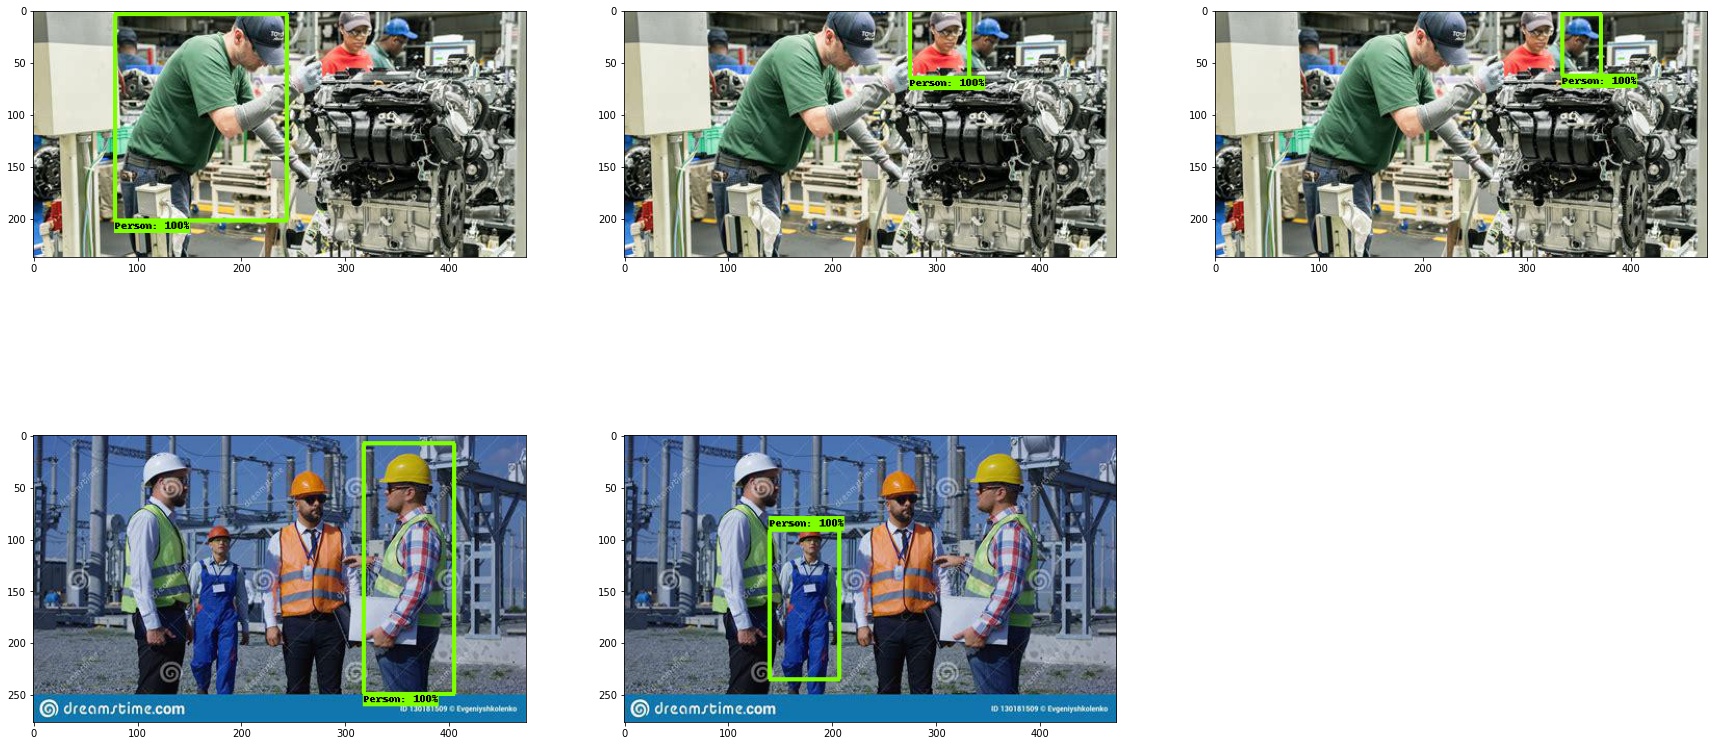

In [11]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

## Load mobile-friendly model

In this cell we build a mobile-friendly single-stage detection architecture (SSD MobileNet V2 FPN-Lite) and restore all but the classification layer at the top (which will be randomly initialized).

**NOTE**: TensorFlow Lite only supports SSD models for now.

For simplicity, we have hardcoded a number of things in this colab for the specific SSD architecture at hand (including assuming that the image size will always be 320x320), however it is not difficult to generalize to other model configurations (`pipeline.config` in the zip downloaded from the [Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.)).




In [12]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!if [ -d "models/research/object_detection/test_data/checkpoint" ]; then rm -Rf models/research/object_detection/test_data/checkpoint; fi
!mkdir models/research/object_detection/test_data/checkpoint
!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-01-19 23:08:48--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.2.112, 2607:f8b0:4004:800::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.2.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.3’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  --.-KB/s    in 0.05s   

2021-01-19 23:08:49 (380 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.3’ saved [20515344/20515344]



In [13]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# This will be where we save checkpoint & config for TFLite conversion later.
output_directory = 'output/'
output_checkpoint_dir = os.path.join(output_directory, 'checkpoint')

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)
# Save new pipeline config
pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_proto, output_directory)

# Set up object-based checkpoint restore --- SSD has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# To save checkpoint for TFLite conversion.
exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(
    exported_ckpt, output_checkpoint_dir, max_to_keep=1)

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 320, 320, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
INFO:tensorflow:Writing pipeline config file to output/pipeline.config
Weights restored!


## Eager training loop (Fine-tuning)

Some of the parameters in this block have been set empirically: for example, `learning_rate`, `num_batches` & `momentum` for SGD. These are just a starting point, you will have to tune these for your data & model architecture to get the best results.





In [14]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 5
learning_rate = 0.15
num_batches = 1000

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function(experimental_relax_shapes=True)
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 320x320.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[320, 320, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 100 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

ckpt_manager.save()
print('Checkpoint saved!')

Start fine-tuning!


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:440: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


batch 0 of 1000, loss=1.2780886
batch 100 of 1000, loss=0.15953456
batch 200 of 1000, loss=0.24272043
batch 300 of 1000, loss=0.20540765
batch 400 of 1000, loss=0.17236906
batch 500 of 1000, loss=0.18056256
batch 600 of 1000, loss=0.16405068
batch 700 of 1000, loss=0.21342331
batch 800 of 1000, loss=0.19162266
batch 900 of 1000, loss=0.17208357
Done fine-tuning!
Checkpoint saved!


# Export & run with TensorFlow Lite



## Model Conversion

First, we invoke the `export_tflite_graph_tf2.py` script to generate a TFLite-friendly intermediate SavedModel. This will then be passed to the TensorFlow Lite Converter for generating the final model.

To know more about this process, please look at [this documentation](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_on_mobile_tf2.md).

In [15]:
%%bash
python models/research/object_detection/export_tflite_graph_tf2.py \
  --pipeline_config_path output/pipeline.config \
  --trained_checkpoint_dir output/checkpoint \
  --output_directory tflite

2021-01-19 23:14:56.339817: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-01-19 23:14:56.339856: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-01-19 23:14:58.238386: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-19 23:14:58.243698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-19 23:14:58.244255: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1760] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 dev

In [16]:
!tflite_convert --saved_model_dir=tflite/saved_model --output_file=tflite/model.tflite

2021-01-19 23:15:33.880446: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-01-19 23:15:33.880493: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-01-19 23:15:35.729738: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-19 23:15:35.734924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-19 23:15:35.735505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1760] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 dev

## Test .tflite model

In [19]:
test_image_dir = 'models/research/object_detection/data/'
test_images_np = []
# for i in df_tagged_images:
#   image_path = os.path.join(test_image_dir, 'out' + str(i) + '.png')
#   test_images_np.append(np.expand_dims(
#       load_image_into_numpy_array(image_path), axis=0))

for i in person_tags["id"].tolist():
  image_path = os.path.join(test_image_dir, str(i) + '.png')
  test_images_np.append(np.expand_dims(load_image_into_numpy_array(image_path), axis=0))

test_images_np

[array([[[[138, 142, 128],
          [138, 142, 127],
          [137, 141, 126],
          ...,
          [165, 171, 159],
          [169, 175, 161],
          [169, 175, 161]],
 
         [[136, 140, 126],
          [135, 139, 124],
          [134, 138, 123],
          ...,
          [168, 174, 162],
          [167, 173, 159],
          [167, 173, 159]],
 
         [[132, 136, 122],
          [132, 136, 121],
          [131, 135, 120],
          ...,
          [168, 174, 162],
          [166, 172, 158],
          [166, 172, 158]],
 
         ...,
 
         [[ 65, 106, 188],
          [ 52,  97, 178],
          [ 41,  90, 167],
          ...,
          [187, 190, 169],
          [194, 197, 176],
          [190, 193, 172]],
 
         [[ 89, 110, 173],
          [109, 131, 189],
          [147, 170, 222],
          ...,
          [192, 195, 174],
          [190, 193, 172],
          [185, 188, 167]],
 
         [[105, 122, 176],
          [117, 131, 178],
          [147, 157, 192],
   

In [20]:
# Again, uncomment this decorator if you want to run inference eagerly
def detect(interpreter, input_tensor):
  """Run detection on an input image.

  Args:
    interpreter: tf.lite.Interpreter
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # We use the original model for pre-processing, since the TFLite model doesn't
  # include pre-processing.
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  interpreter.set_tensor(input_details[0]['index'], preprocessed_image.numpy())

  interpreter.invoke()

  boxes = interpreter.get_tensor(output_details[0]['index'])
  classes = interpreter.get_tensor(output_details[1]['index'])
  scores = interpreter.get_tensor(output_details[2]['index'])
  return boxes, classes, scores

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  boxes, classes, scores = detect(interpreter, input_tensor)

  plot_detections(
      test_images_np[i][0],
      boxes[0],
      classes[0].astype(np.uint32) + label_id_offset,
      scores[0],
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

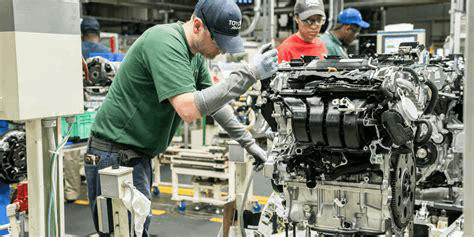

In [22]:
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=2)

display(IPyImage(open(anim_file, 'rb').read()))

## (Optional) Download model

This model can be run on-device with **TensorFlow Lite**. Look at [our SSD model signature](https://www.tensorflow.org/lite/models/object_detection/overview#uses_and_limitations) to understand how to interpret the model IO tensors. Our [Object Detection example](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection) is a good starting point for integrating the model into your mobile app.

Refer to TFLite's [inference documentation](https://www.tensorflow.org/lite/guide/inference) for more details.

In [ ]:
from google.colab import files
files.download('tflite/model.tflite') 